# 기능적 API

## 설정

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 시작하기

Keras *함수형 API*는 `tf.keras.Sequential` API보다 더 유연한 모델을 생성하는 방법입니다. 함수형 API는 비선형 토폴로지, 공유 레이어, 심지어 여러 입력 또는 출력이 있는 모델을 처리할 수 있습니다.

주요 개념은 딥 러닝 모델은 일반적으로 레이어의 DAG(directed acyclic graph)라는 것입니다. 따라서 함수형 API는 *레이어의 그래프*를 빌드하는 방법입니다.

다음 모델을 고려하십시오.

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

이 모델은 세 개의 레이어가 있는 기본 그래프입니다. 함수형 API를 사용하여 이 모델을 빌드하려면 먼저 입력 노드를 작성하세요.

In [45]:
inputs = keras.Input(shape=(784,))   # (None,784)

데이터의 모양은 784 차원 벡터로 설정됩니다. 각 샘플의 모양 만 지정되므로 배치 크기는 항상 생략됩니다.

예를 들어 `(32, 32, 3)` 모양의 이미지 입력이있는 경우 다음을 사용합니다.

In [46]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))  # (None,32,32,3)

리턴되는 `inputs` 에는 모델에 공급하는 입력 데이터의 모양 및 `dtype` 에 대한 정보가 포함됩니다. 모양은 다음과 같습니다.

In [47]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


dtype은 다음과 같습니다.

In [48]:
inputs.dtype

tf.float32

이 `inputs` 객체에서 레이어를 호출하여 레이어 그래프에서 새 노드를 만듭니다.

In [49]:
dense = layers.Dense(64, activation="relu")
print(dense.weights)
x = dense(inputs)  # (None,784)(784,64)+(64,) => (None,64)

[]


In [50]:
print(dense.weights)

[<tf.Variable 'dense_3/kernel:0' shape=(784, 64) dtype=float32, numpy=
array([[-0.0503418 , -0.0216522 ,  0.02128652, ...,  0.03491111,
        -0.04479966,  0.05081301],
       [ 0.07442548,  0.06908301, -0.01545566, ..., -0.00621327,
         0.05467167,  0.01506176],
       [-0.06954069,  0.07328843,  0.06208438, ..., -0.06886549,
         0.02640225,  0.07910315],
       ...,
       [ 0.05463047,  0.02520486,  0.0716266 , ..., -0.02455813,
         0.03792179,  0.08186493],
       [ 0.02911047,  0.06119619,  0.05021683, ..., -0.03008952,
         0.04719498,  0.01716547],
       [ 0.03716451, -0.02740758,  0.02419577, ...,  0.02703049,
         0.00262134, -0.0468504 ]], dtype=float32)>, <tf.Variable 'dense_3/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.,

In [51]:
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense_3/Relu:0', description="created by layer 'dense_3'")


"레이어 호출" 동작은 "입력"에서 생성된 레이어로 화살표를 그리는 것과 같습니다. 입력을 `dense` 레이어로 "전달"하고 `x`를 출력으로 가져옵니다.

레이어 그래프에 레이어를 몇 개 레이어를 더 추가해 보겠습니다.

### callable interface

In [52]:
class AAA():
    def __init__(self, num):
        print("생성자", num)
        
    def foo(self):
        print("foo()")

In [53]:
a = AAA(10)
print(a)
a.foo()
a()

생성자 10
foo()


TypeError: 'AAA' object is not callable

In [54]:
class AAA():
    def __init__(self, num):
        print("생성자", num)
        
    def foo(self):
        print("foo()")
        
    def __call__(self, data):
        print("__call__()",data)
        
a = AAA(100)
a.foo()
a(10)

AAA(100)(10)

생성자 100
foo()
__call__() 10
생성자 100
__call__() 10


In [55]:
x = layers.Dense(64, activation="relu")(x)   # (None,64)(64,64)+(64,) => (None,64)
print(x)
outputs = layers.Dense(10)(x)                # (None,64)(64,10)+(10,) => (None,10)
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense_4/Relu:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_5/BiasAdd:0', description="created by layer 'dense_5'")


이 시점에서 레이어 그래프에서 입력 및 출력을 지정하여 `Model`을 작성할 수 있습니다.

In [56]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

모델 요약이 어떻게 보이는지 확인하십시오.

In [57]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


모델을 그래프로 플롯 할 수도 있습니다.

pydot 설치  
  - 아나콘다 파워쉘 실행
  
콘다로 설치  
  - conda install pydot
 
또는 
  - pip install pydot 
  - pip install pydotplus
  - pip install graphviz

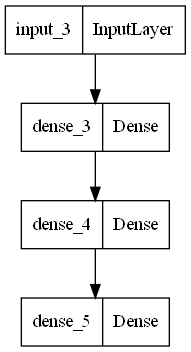

In [58]:
keras.utils.plot_model(model, "my_first_model.png")

그리고 선택적으로 플롯 된 그래프에 각 레이어의 입력 및 출력 모양을 표시합니다.

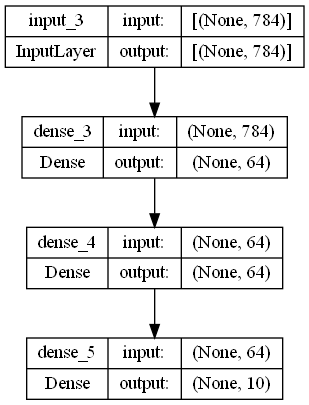

In [59]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

이 그림과 코드는 거의 동일합니다. 코드 버전에서 연결 화살표는 호출 작업으로 대체됩니다.

"레이어 그래프"는 딥 러닝 모델을위한 직관적 인 정신 이미지이며 함수형 API는이를 밀접하게 반영하는 모델을 만드는 방법입니다.

## 교육, 평가 및 추론

훈련, 평가 및 추론은 `Sequential` 모델과 같이 함수형 API를 사용하여 빌드된 모델에 대해 같은 방식으로 작동합니다.

`Model` 클래스는 내장 훈련 루프(`fit()` 메서드)와 내장 평가 루프(`evaluate()` 메서드)를 제공합니다. [이러한 루프를 쉽게 사용자 정의](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/)하여 지도 학습(예: [GANs](/examples/generative/dcgan_overriding_train_step/)) 이상의 학습 루틴을 구현할 수 있습니다.

여기에서 MNIST 이미지 데이터를로드하고 벡터로 재구성하고 데이터에 모델을 맞추고 (유효성 분할에서 성능을 모니터링하는 동안) 테스트 데이터에서 모델을 평가하십시오.

In [60]:
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# print(x_train.shape)
# print(y_train.shape)

# print(y_train[1])
# plt.imshow(x_train[1], cmap='gray')
# plt.show()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

# print(x_train[0])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2) # (64,784)

print(x_test.shape)
print(y_test.shape)

test_scores = model.evaluate(x_test, y_test, verbose=2)
# print(test_scores)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.3509 - accuracy: 0.9014 - val_loss: 0.1961 - val_accuracy: 0.9433
Epoch 2/2
750/750 [==============================] - 3s 4ms/step - loss: 0.1672 - accuracy: 0.9503 - val_loss: 0.1432 - val_accuracy: 0.9573
(10000, 784)
(10000,)
313/313 - 0s - loss: 0.1407 - accuracy: 0.9571 - 401ms/epoch - 1ms/step
Test loss: 0.1407179832458496
Test accuracy: 0.957099974155426


1/1 [==============================] - 0s 34ms/step
예측:8
정답:9


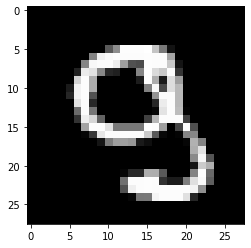

In [40]:
for idx in range(1000):
    y = model.predict(x_test[idx:idx+1,:])   # (1,784)
    if np.argmax(y) != y_test[idx]:
        print("예측:%d"%np.argmax(y))
        print("정답:%d"%y_test[idx])
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.show()
        break

자세한 내용은 [훈련 및 평가](https://www.tensorflow.org/guide/keras/train_and_evaluate/) 가이드를 참조하세요.

## 저장 및 직렬화

모델 저장 및 직렬화는 `Sequential` 모델과 같이 함수형 API를 사용하여 빌드된 모델에 대해 같은 방식으로 작동합니다. 함수형 모델을 저장하는 표준 방법은 `model.save()`를 호출하여 전체 모델을 단일 파일로 저장하는 것입니다. 모델을 빌드한 코드를 더 이상 사용할 수 없는 경우에도 나중에 이 파일에서 같은 모델을 다시 작성할 수 있습니다.

저장된 이 파일에는 다음이 포함됩니다.

- 모델 아키텍처
- 모델 중량 값 (훈련 중 학습 된 값)
- 모델 훈련 구성(있는 경우, `compile`로 전달)
- 옵티마이저 및 상태(있는 경우, 중단한 곳에서 훈련을 다시 시작)

In [61]:
model.save("my_model")
del model

INFO:tensorflow:Assets written to: my_model\assets


In [62]:
# Recreate the exact same model purely from the file:
model = keras.models.load_model("my_model")
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 0s - loss: 0.1407 - accuracy: 0.9571 - 453ms/epoch - 1ms/step
Test loss: 0.1407179832458496
Test accuracy: 0.957099974155426


자세한 내용은 모델 [직렬화 및 저장](https://www.tensorflow.org/guide/keras/save_and_serialize/) 가이드를 참조하세요.

## 같은 레이어 그래프를 사용하여 여러 모델 정의하기

함수형 API에서 모델은 레이어 그래프에 입력 및 출력을 지정하여 생성됩니다. 즉, 단일 레이어 그래프를 사용하여 여러 모델을 생성할 수 있습니다.

아래 예에서는 같은 레이어 스택을 사용하여 두 모델을 인스턴스화합니다. 이미지 입력을 16차원 벡터로 변환하는 `encoder` 모델과 훈련을 위한 엔드 투 엔드 `autoencoder` 모델입니다.

In [64]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input) # (None,26,26,16)
x = layers.Conv2D(32, 3, activation="relu")(x)             # (None,24,24,32)
x = layers.MaxPooling2D(3)(x)                              # (None,8,8,32)
x = layers.Conv2D(32, 3, activation="relu")(x)             # (None,6,6,32)
x = layers.Conv2D(16, 3, activation="relu")(x)             # (None,4,4,16)
encoder_output = layers.GlobalMaxPooling2D()(x)            # (None,16)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)             # (None,4,4,1)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)   # (None,6,6,16)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)   # (None,8,8,32)
x = layers.UpSampling2D(3)(x)                             # (None,24,24,32)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)   # (None,26,26,16)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)  # (None,28,28,1)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      
                                                       

여기서, 디코딩 아키텍처는 인코딩 아키텍처와 완전하게 대칭이므로 출력 형상은 입력 형상 `(28, 28, 1)`과 같습니다.

(A)의 반대 `Conv2D` 층은 인 `Conv2DTranspose` 층, 및의 역 `MaxPooling2D` 층은 인 `UpSampling2D` 층.

## 레이어와 마찬가지로, 모든 모델은 callable입니다

`Input` 또는 또 다른 레이어의 출력에서 모델을 호출함으로써 모델을 마치 레이어와 같이 취급할 수 있습니다. 모델을 호출함으로써 모델의 아키텍처를 재사용할 뿐만 아니라 가중치도 재사용합니다.

실례를 위해, 다음은 인코더 모델과 디코더 모델을 만들고 두 번의 호출로 연결하여 자동 인코더 모델을 얻는 자동 인코더 예제에 대한 또 다른 설명입니다.

In [65]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

보시다시피, 모델은 중첩될 수 있습니다. 모델은 하위 모델을 포함할 수 있습니다(모델은 레이어와 유사하므로). 모델 중첩의 일반적인 사용 사례는 *앙상블 기법(ensembling)*입니다. 예를 들어, 모델 세트를 단일 모델로 앙상블하여 예측을 평균화하는 방법은 다음과 같습니다.

In [66]:
def get_model():
    inputs = keras.Input(shape=(128,))    # (None,128)
    outputs = layers.Dense(1)(inputs)     # (None,128)(128,1)+(1,) => (None,1)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 model (Functional)             (None, 1)            129         ['input_8[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            129         ['input_8[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 1)            129         ['input_8[0][0]']                
                                                                                            

## 복잡한 그래프 토폴로지 조작

### 여러 입력 및 출력 모델

함수형 API를 사용하면 다중 입력 및 출력을 쉽게 조작할 수 있습니다. `Sequential` API로는 처리할 수 ​​없습니다.

예를 들어 우선 순위별로 사용자 지정 발급 티켓 순위를 매기고 올바른 부서로 라우팅하는 시스템을 구축하는 경우 모델에는 세 가지 입력이 있습니다.

- 티켓의 제목 (텍스트 입력)
- 티켓의 본문 (텍스트 입력)
- 사용자가 추가 한 모든 태그 (범주 입력)

이 모델에는 두 가지 출력이 있습니다.

- 0과 1 사이의 우선 순위 점수 (스칼라 시그 모이 드 출력)
- 티켓을 처리해야하는 부서 (부서 세트에 대한 softmax 출력)

함수형 API를 사용하여 이 모델을 몇 줄로 빌드할 수 있습니다.

In [69]:
title_input = keras.Input(
    shape=(None,), name="title"
)
print(title_input)
title_features = layers.Embedding(10000, 64)(title_input)
print(title_features)
title_features = layers.LSTM(128)(title_features)
print(title_features)

KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='title'), name='title', description="created by layer 'title'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None), name='embedding_1/embedding_lookup/Identity_1:0', description="created by layer 'embedding_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='lstm/PartitionedCall:0', description="created by layer 'lstm'")


In [70]:
body_input = keras.Input(shape=(None,), name="body") 
print(body_input)
body_features = layers.Embedding(10000, 64)(body_input)
print(body_features)
body_features = layers.LSTM(32)(body_features)
print(body_features)

KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='body'), name='body', description="created by layer 'body'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None), name='embedding_2/embedding_lookup/Identity_1:0', description="created by layer 'embedding_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:0', description="created by layer 'lstm_1'")


In [71]:
tags_input = keras.Input(
    shape=(12,), name="tags"
)
print(tags_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name='tags'), name='tags', description="created by layer 'tags'")


In [72]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input]) # (None,128),(None,32),(None,12)

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)   # (None,172)(172,1)+(1,) => (None,1)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x) # (None,172)(172,4)+(4,) => (None,4)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

이제 모델을 플롯합니다.

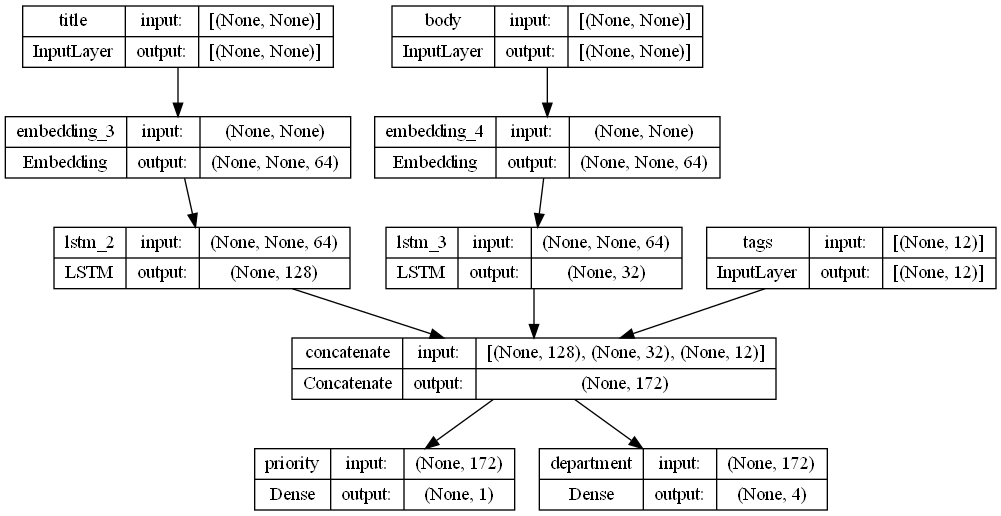

In [73]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

이 모델을 컴파일 할 때 각 출력에 서로 다른 손실을 할당 할 수 있습니다. 각 손실에 다른 가중치를 할당하여 총 교육 손실에 대한 기여도를 조정할 수도 있습니다.

In [74]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

출력 레이어의 이름이 다르므로 손실을 다음과 같이 지정할 수도 있습니다.

In [75]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

입력 및 목표치의 NumPy 배열 목록을 전달하여 모델을 훈련합니다.

In [76]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 9s 60ms/step - loss: 1.2919 - priority_loss: 0.7034 - department_loss: 2.9426
Epoch 2/2
40/40 [==============================] - 3s 70ms/step - loss: 1.2784 - priority_loss: 0.6994 - department_loss: 2.8948


`Dataset` 객체에 맞춰 호출하면 `([title_data, body_data, tags_data], [priority_targets, dept_targets])`와 같은 목록의 튜플 또는 `({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`와 같은 사전의 튜플이 산출됩니다.

자세한 설명은 [교육 및 평가](https://www.tensorflow.org/guide/keras/train_and_evaluate/) 안내서를 참조하십시오.

### 장난감 ResNet 모델

입력 및 출력이 여러 개인 모델 외에도 함수형 API를 사용하면 비선형 연결 토폴로지를 쉽게 조작할 수 있습니다. 이들은 순차적으로 연결되지 않은 레이어가 있는 모델이며 `Sequential` API가 처리할 수 없는 모델입니다.

이에 대한 일반적인 사용 사례는 나머지 연결(residual connections)입니다. 실례를 위해 CIFAR10을 위한 장난감 ResNet 모델을 만들어 봅시다.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)  # (None,32,32,3)(3,3,3,32)
x = layers.Conv2D(64, 3, activation="relu")(x)       # (None,30,30,32)(3,3,32,64)
block_1_output = layers.MaxPooling2D(3)(x)           # (None,28,28,64) => (None,9,9,64)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])    # (None,9,9,64)+(None,9,9,64)=>(None,9,9,64)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

모델을 플롯합니다.

In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

이제 모델을 훈련합니다.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

## 공유 레이어

함수형 API의 또 다른 유용한 용도는 *공유 레이어*를 사용하는 모델입니다. 공유 레이어는 같은 모델에서 여러 번 재사용되는 레이어 인스턴스입니다. 레이어 그래프에서 여러 경로에 해당하는 특성을 학습합니다.

공유 레이어는 종종 비슷한 공간(예: 유사한 어휘를 제공하는 두 개의 서로 다른 텍스트 조각)의 입력을 인코딩하는 데 사용됩니다. 공유 레이어는  서로 다른 입력 간에 정보를 공유할 수 있으며 적은 데이터에서 모델을 훈련할 수 있습니다. 지정된 단어가 입력 중 하나에 표시되면 공유 레이어를 통해 전달하는 모든 입력을 처리하는 데 도움이 됩니다.

함수형 API에서 레이어를 공유하려면, 같은 레이어 인스턴스를 여러 번 호출합니다. 예를 들어, 다음은 두 가지 서로 다른 텍스트 입력 간에 공유되는 `Embedding` 레이어입니다.

In [ ]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## 레이어 그래프에서 노드 추출 및 재사용

조작하는 레이어의 그래프는 정적 데이터 구조이므로 액세스하여 검사할 수 있습니다. 이를 통해 함수형 모델을 이미지로 플롯할 수 있습니다.

즉, 중간 레이어(그래프의 "노드")의 활성화에 액세스하여 다른 곳에 재사용할 수 있습니다. 이는 특성 추출과 같은 경우에 매우 유용합니다.

예를 봅시다. ImageNet에 가중치가 사전 훈련 된 VGG19 모델입니다.

In [ ]:
vgg19 = tf.keras.applications.VGG19()

In [ ]:
len(vgg19.layers)

다음은 그래프 데이터 구조를 쿼리하여 얻은 모델의 중간 활성화입니다.

In [ ]:
features_list = [layer.output for layer in vgg19.layers]
print(features_list)

In [ ]:
print(vgg19.input)

다음 특성을 사용하여 중간 레이어 활성화의 값을 반환하는 새로운 feature-extraction 모델을 만듭니다.

In [ ]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)
for extracted_feature in extracted_features:
    print(extracted_feature.shape)

이 모델은 [뉴런 스타일 전송](https://keras.io/examples/generative/neural_style_transfer/)과 같은 작업에 특히 유용합니다.

## 사용자 정의 레이어를 사용하여 API 확장

`tf.keras` 는 다음과 같은 광범위한 내장 레이어를 포함합니다.

- 컨볼루션 레이어: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranspose`
- 풀링 레이어 : `MaxPooling1D` , `MaxPooling2D` , `MaxPooling3D` , `AveragePooling1D`
- RNN 레이어 : `GRU` , `LSTM` , `ConvLSTM2D`
- `BatchNormalization` , `Dropout` , `Embedding` 등

그러나 필요한 것을 찾지 못하면 자신의 레이어를 만들어 API를 쉽게 확장 할 수 있습니다. 모든 레이어는 `Layer` 클래스를 서브 클래 싱하고 다음을 구현합니다.

- 레이어에 의해 수행되는 계산을 지정하는 `call` 메소드.
- `build` 레이어의 가중치를 생성하는 방법, (당신이 무게를 만들 수 있기 때문에이 단지 스타일의 규칙입니다 `__init__` 뿐만 아니라,).

처음부터 레이어를 만드는 방법에 대한 자세한 내용은 [사용자 정의 레이어 및 모델](https://www.tensorflow.org/guide/keras/custom_layers_and_models) 안내서를 참조하십시오.

다음은 `tf.keras.layers.Dense` 의 기본 구현입니다.

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units
        print("CustomDense.__init__()")

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )
        print("CustomDense.build()")

    def call(self, inputs):
        print("CustomDense.call()")
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

사용자 정의 레이어에서 직렬화를 지원하려면, 레이어 인스턴스의 constructor 인수를 반환하는 `get_config` 메서드를 정의합니다.

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

print(config)

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

선택적으로, config 사전이 주어진 레이어 인스턴스를 다시 작성할 때 사용되는 클래스 메서드 `from_config(cls, config)`를 구현합니다. `from_config`의 기본 구현은 다음과 같습니다.

```python
def from_config(cls, config):
  return cls(**config)
```

## 기능적 API를 사용하는 경우

언제 Keras 함수형 API를 사용하여 새 모델을 작성하거나 `Model` 클래스를 직접 하위 클래스화해야 할까요? 일반적으로, 함수형 API는 고수준의 쉽고 안전하며, 하위 클래스화되지 않은 모델에서 지원하지 않는 많은 특성을 가지고 있습니다.

그러나 모델 하위 클래스화는 레이어의 방향성 비순환 그래프로 쉽게 표현할 수 없는 모델을 빌드할 때 더 큰 유연성을 제공합니다. 예를 들어, 함수형 API로 Tree-RNN을 구현할 수 없었으며 `Model`을 직접 하위 클래스화해야 했습니다.

함수형 API와 모델 하위 클래스화의 차이점에 대한 자세한 내용은 [TensorFlow 2.0의 기호 및 명령형 API란 무엇입니까?](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html)를 참조하세요.

### 기능적 API 강점 :

다음 특성은 Sequential 모델(데이터 구조이기도 함)에도 적용되지만, 하위 클래스화된 모델(데이터 구조가 아닌 파이썬 바이트 코드)에는 적용되지 않습니다.

#### 덜 복잡하다

`super(MyClass, self).__init__(...)` , `def call(self, ...):` 등이 없습니다.

비교:

```python
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)
```

하위 클래스화된 버전:

```python
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))
```

#### 연결 그래프를 정의하면서 모델을 검증한다

함수형 API에서는 입력 사양(형상 및 dtype)이 사전에 작성됩니다 (`Input` 사용). 레이어를 호출할 때마다 레이어는 전달된 사양이 해당 가정과 일치하는지 확인하고 그렇지 않은 경우 유용한 오류 메시지를 발생시킵니다.

이를 통해 함수형 API로 빌드할 수 있는 모든 모델이 실행됩니다. 수렴 관련 디버깅 이외의 모든 디버깅은 실행 중이 아니라 모델 구성 중에 정적으로 발생합니다. 이것은 컴파일러에서의 유형 검사와 유사합니다.

#### 함수형 모델은 플롯 및 검사 가능하다

모델을 그래프로 플롯하고, 이 그래프에서 중간 노드에 쉽게 액세스할 수 있습니다. 예를 들어, 중간 레이어의 활성화를 추출하여 재사용합니다(이전 예제에서 볼 수 있음).

```python
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
```

#### 함수형 모델은 직렬화 또는 복제 가능하다

함수형 모델은 코드가 아닌 데이터 구조이기 때문에 안전하게 직렬화할 수 있으며 단일 코드로 저장하여 원본 코드에 액세스하지 않고도 정확히 같은 모델을 다시 만들 수 있습니다. [직렬화 및 저장 안내서](https://www.tensorflow.org/guide/keras/save_and_serialize/)를 참조하세요.

하위 클래스화된 모델을 직렬화하려면 구현자가 모델 레벨에서 `get_config()` 및 `from_config()` 메서드를 지정해야 합니다.

### 기능적 API 약점 :

#### 동적 아키텍처를 지원하지 않는다

함수형 API는 모델을 레이어의 DAG로 취급합니다. 이는 대부분의 딥 러닝 아키텍처에 해당하지만, 전부는 아닙니다. 예를 들어, 재귀 네트워크 또는 트리 RNN은 이 가정을 따르지 않으며 함수형 API로 구현할 수 없습니다.

## 믹스 앤 매치 API 스타일

함수형 API 또는 Model 하위 클래스화 중에서 선택하는 것은 하나의 모델 범주로 제한하는 이진 결정이 아닙니다. `tf.keras` API의 모든 모델은 `Sequential` 모델, 함수형 모델 또는 처음부터 작성한 하위 클래스화된 모델과 관계없이 서로 상호 작용할 수 있습니다.

하위 클래스화된 모델 또는 레이어의 일부로 함수형 모델 또는 `Sequential` 모델을 항상 사용할 수 있습니다.

In [ ]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
out = rnn_model(tf.zeros((1, timesteps, input_dim)))
print(out.shape)

다음 패턴 중 하나를 따르는 `call` 메서드를 구현하는 한 함수형 API에서 하위 클래스화된 레이어 또는 모델을 사용할 수 있습니다.

- `call(self, inputs, **kwargs)` - `inputs`는 텐서 또는 텐서의 중첩 구조(예: 텐서의 목록)이며, `**kwargs`는 비 텐서 인수(non-inputs)입니다.
- `call(self, inputs, training=None, **kwargs)` - `training`은 레이어가 훈련 모드 및 추론 모드에서 동작해야 하는지 여부를 나타내는 boolean입니다.
- `call(self, inputs, mask=None, **kwargs)` - `mask`는 boolean 마스크 텐서(예를 들어, RNN에 유용)입니다.
- `call(self, inputs, training=None, mask=None, **kwargs)` -물론 마스킹과 교육 별 동작을 동시에 가질 수 있습니다.

또한, 사용자 정의 Layer 또는 모델에서 `get_config` 메서드를 구현하면 작성하는 함수형 모델은 계속 직렬화 가능하고 복제 가능합니다.

다음은 함수형 모델에 사용되는 처음부터 작성된 사용자 정의 RNN의 간단한 예입니다.

In [ ]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))  # (16,10,5)
x = layers.Conv1D(32, 3)(inputs)   # N-F+1 => 10-3+1 => (16,8,32)
print(x.shape)
outputs = CustomRNN()(x)
print(outputs.shape)   #(16,8,1)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
out = rnn_model(tf.zeros((1, 10, 5)))
print(out.shape)